In [ ]:
import os
import glob
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.fft import fft
from data_preprocess import DivideData

In [2]:
class UnsupervisedClassify():
    
    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.tasks = pd.read_csv('/home/Shared/xinyi/blob1/thesis/data/task.csv')
    def rx_values(self, i_values, q_values):
        """
        use to merge the i and q channels
        :param i_values: e.g.'rx1_freq_a_channel_i_data'
        :param q_values: e.g.'rx1_freq_a_channel_q_data'
        :return: merged channels and i and q channels (flattened)
        """
        a1i = np.array([np.array(row) for row in i_values])
        a1q = np.array([np.array(row) for row in q_values])

        n = np.array(range(256)) / 256
        f_c = 24_000_000_000  # 24 GHz
        v = 2.0 * np.pi * f_c * n

        value_rx = a1i * np.cos(v) + a1q + np.sin(v)
        return value_rx, a1i, a1q

    def prepare_merged_channels(self, dt):
        rx1_a_i = dt['rx1_freq_a_channel_i_data']
        rx1_a_q = dt['rx1_freq_a_channel_q_data']
        rx2_a_i = dt['rx2_freq_a_channel_i_data']
        rx2_a_q = dt['rx2_freq_a_channel_q_data']
        rx1_b_i = dt['rx1_freq_b_channel_i_data']
        rx1_b_q = dt['rx1_freq_b_channel_q_data']
        # merge!
        a1_rx, a1_i_values, a1_q_values = self.rx_values(i_values=rx1_a_i, q_values=rx1_a_q)
        a2_rx, a2_i_values, a2_q_values = self.rx_values(i_values=rx2_a_i, q_values=rx2_a_q)
        b1_rx, b1_i_values, b1_q_values = self.rx_values(i_values=rx1_b_i, q_values=rx1_b_q)  
        # return a1_rx, a2_rx, b1_rx do need this step for adding them to the df !!!
        a1_rx_nested_arr = a1_rx.tolist()
        a2_rx_nested_arr = a2_rx.tolist()
        b1_rx_nested_arr = b1_rx.tolist()

        return a1_rx_nested_arr, a2_rx_nested_arr, b1_rx_nested_arr

    def flatten_df(self, df):
        df = df.iloc[:, :6]
        a1_rx, a2_rx, b1_rx = self.prepare_merged_channels(df)
        df['a1_rx'] = a1_rx
        df['a2_rx'] = a2_rx
        df['b1_rx'] = b1_rx
        part_arr = np.empty((9, 1), dtype=object)

        k = 0
        for col in df.columns:
            data_series = df[col]
            data_series_exploded = data_series.explode(col)
            merged_list = data_series_exploded.tolist()
            part_arr[k, 0] = merged_list
            k += 1
        df_new = pd.DataFrame(part_arr.T, columns=df.columns)
        return df_new
    def divide_task_index(self, participant):
        """
        for each participant df, annotate by tasks
        task info: T_1: uuid, T_2: uuid, ...
        :param participant: df for one participant
        :return: dictionary of {T_1: [position], T_2: [position], ...}
        """
        tasks = self.tasks
        task_index = {}
        # need to change the number of range according to the task number
        for i in range(15):
            T = participant[participant['task_uuid'] == tasks['UUID'][i]].index
            T = np.array(T) * 256
            task_index[f'T_{i}'] = T

        try:
            task_max = {key: value[-1] for key, value in task_index.items()}
            task_min = {key: value[0] for key, value in task_index.items()}
            merged_ind = {key: (task_min[key], task_max[key]) for key in task_index.keys()}
            return merged_ind
        except:
            print("cannot find task index")


### Prepare data <br>

In [60]:
def prepare_task_file(task_index, data, name):# per participant
    roi_task = ['T_0', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7', 'T_8', 'T_9', 'T_10']
    col_names = ['rx1_freq_a_channel_i_data', 'rx1_freq_a_channel_q_data',
                 'rx2_freq_a_channel_i_data', 'rx2_freq_a_channel_q_data',
                 'rx1_freq_b_channel_i_data', 'rx1_freq_b_channel_q_data', 'fft']
    part_all_tasks = []
    try:
        for key, value in task_index.items():
            if key in roi_task:# key: T_0, T_1, ...
                start, end = value
                task_arr = np.empty((7, 1))
                task_num = int(key.split('_')[1])
                for k, col in enumerate(col_names):
                    # exploded the 2D array to a 1D list, for plotting and computation
                    data_series = data[col]
                    data_series_exploded = data_series.explode(col)
                    merged_list = data_series_exploded.tolist()
                    task_l = merged_list[start:(end+1)]
                    task_arr[k,0] = task_l
                df_new = pd.DataFrame(task_arr.T, columns=col_names)
                df_new['task'] = None
                df_new.at[0, 'task'] = task_num
                part_all_tasks.append(df_new)
        df = pd.DataFrame(part_all_tasks, columns=col_names)
    except Exception as e:
        print('sth went wrong @_@')
    #df = pd.DataFrame(task_arr.T, columns=col_names)
    #df.to_parquet(f'{name}.parquet', engine='fastparquet')  

In [6]:
roi_task = ['T_0', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7', 'T_8', 'T_9', 'T_10']
col_names = ['rx1_freq_a_channel_i_data', 'rx1_freq_a_channel_q_data']
             #'rx2_freq_a_channel_i_data', 'rx2_freq_a_channel_q_data',
             #'rx1_freq_b_channel_i_data', 'rx1_freq_b_channel_q_data', 'fft']
part_all_tasks = []
part_1 = part['participant_3']
part_1 = part_1.reset_index(drop=True)
task_index = unsupervied_classify.divide_task_index(part_1)
col = 'rx1_freq_a_channel_i_data'
task_arr = np.empty((11, 1), dtype=object)
for key, value in task_index.items():
    if key in roi_task:# key: T_0, T_1, ...
        start, end = value
        task_num = int(key.split('_')[1])
        data_series = part_1[col]
        data_series_exploded = data_series.explode(col)
        merged_list = data_series_exploded.tolist()
        task_l = merged_list[start:(end+1)]
        task_arr[task_num, 0] = task_l
    #df_new = pd.DataFrame(task_arr.T, columns=col_names)

In [7]:

df_new = pd.DataFrame(task_arr)

In [8]:
df_new['task'] = df_new.index
df_new.rename(columns={df_new.columns[0]: 'rx1_freq_a_channel_i_data'}, inplace=True)
# this is the new way to generate task data for each participant

In [9]:
df_new

,rx1_freq_a_channel_i_data,task
0,"[34256.0, 34224.0, 34176.0, 34224.0, 34176.0, ...",0
1,"[34128.0, 34208.0, 34080.0, 34096.0, 34224.0, ...",1
2,"[34096.0, 34080.0, 34000.0, 34144.0, 34144.0, ...",2
3,"[34176.0, 34256.0, 34128.0, 34192.0, 34208.0, ...",3
4,"[34096.0, 34160.0, 34192.0, 34224.0, 34128.0, ...",4
5,"[34240.0, 34064.0, 34192.0, 34112.0, 34176.0, ...",5
6,"[34208.0, 34272.0, 34320.0, 34128.0, 34160.0, ...",6
7,"[34080.0, 34064.0, 34208.0, 34176.0, 34176.0, ...",7
8,"[34176.0, 34160.0, 34160.0, 34128.0, 34080.0, ...",8
9,"[34240.0, 34240.0, 34192.0, 34224.0, 34160.0, ...",9


In [98]:
task_arr.shape

(7, 1)

In [5]:
# Set the base path, subfolders, and task filename
base_dir = '/home/Shared/xinyi/blob1/thesis/data/parquet_samples/'
unsupervied_classify = UnsupervisedClassify(base_dir)
data_file_path = '/home/Shared/xinyi/blob1/thesis/data/parquet_samples/16_06_22/radar_samples_192.168.67.112_397.parquet'
divide_data = DivideData(data_file_path)
part, num = divide_data.divide_participants()
for key, value in enumerate(part):
    data_part = part[value]
    data_part = data_part.reset_index(drop=True)
    task_index = unsupervied_classify.divide_task_index(data_part)
    #df = prepare_task_file(task_index=task_index, data=data_part, name=f'{save_dir}/{value}')

In [61]:
value

'participant_3'

In [23]:
# Set the base path, subfolders, and task filename
base_dir = '/home/Shared/xinyi/blob1/thesis/data/parquet_samples/'
unsupervied_classify = UnsupervisedClassify(base_dir)
radar_no = 112
file_pattern = os.path.join(base_dir, '**', f'radar_samples_192.168.67.{radar_no}*')
# get all file names for this radar
matching_files = glob.glob(file_pattern, recursive=True)
all_participants = []
tasks = pd.read_csv('/home/Shared/xinyi/blob1/thesis/data/task.csv')
save_dir = '/home/Shared/xinyi/blob1/thesis/radar112_participants'
count = 1
for data_path in matching_files:
    divide_data = DivideData(data_path)
    part, num = divide_data.divide_participants()
    for key, value in enumerate(part):
        data_part = part[value]
        data_part = data_part.reset_index(drop=True)
        task_index = unsupervied_classify.divide_task_index(data_part)
        prepare_task_file(task_index=task_index, data=data_part, name=f'{save_dir}/{value}_{count}')
        break
    count += 1
    
#df_new = unsupervied_classify.flatten_df(data_part)
#all_participants.append(df_new)
#df_all_participant = pd.concat(all_participants, ignore_index=True)

cannot find task index
sth went wrong @_@


In [51]:
df

[array([34256., 34224., 34176., ..., 34112., 34048., 34064.]),
 array([34128., 34208., 34080., ..., 34064., 34032., 34128.]),
 array([34096., 34080., 34000., ..., 34000., 34128., 34112.]),
 array([34176., 34256., 34128., ..., 34208., 34128., 34128.]),
 array([34096., 34160., 34192., ..., 34080., 34096., 34160.]),
 array([34240., 34064., 34192., ..., 34176., 34064., 34000.]),
 array([34208., 34272., 34320., ..., 34144., 34112., 34128.]),
 array([34080., 34064., 34208., ..., 34048., 34224., 34128.]),
 array([34176., 34160., 34160., ..., 34192., 33984., 34112.]),
 array([34240., 34240., 34192., ..., 34160., 34224., 34256.]),
 array([34032., 34112., 34080., ..., 34080., 34144., 34112.])]

In [5]:
df_all_participant
custom_index = ['P' + str(i) for i in range(1, len(df_all_participant) + 1)]
df_all_participant.index = custom_index

In [ ]:
df_all_participant.to_parquet('/home/Shared/xinyi/blob1/thesis/radar112_all_part_data2310.parquet')

In [5]:
data = pd.read_parquet('/home/Shared/xinyi/blob1/thesis/radar112_all_part_data2310.parquet')
data

,rx1_freq_a_channel_i_data,rx1_freq_a_channel_q_data,rx2_freq_a_channel_i_data,rx2_freq_a_channel_q_data,rx1_freq_b_channel_i_data,rx1_freq_b_channel_q_data,a1_rx,a2_rx,b1_rx
P1,"[34288.0, 34368.0, 34288.0, 34336.0, 34272.0, ...","[32352.0, 32464.0, 32416.0, 32464.0, 32528.0, ...","[33552.0, 33504.0, 33488.0, 33488.0, 33520.0, ...","[32704.0, 32736.0, 32720.0, 32720.0, 32656.0, ...","[34144.0, 34224.0, 34224.0, 34224.0, 34288.0, ...","[32832.0, 32848.0, 32816.0, 32848.0, 32720.0, ...","[66640.0, 66831.9999999341, 66703.99999986804,...","[66256.0, 66239.9999999341, 66207.99999986804,...","[66976.0, 67071.9999999341, 67039.99999986804,..."
P2,"[33952.0, 34192.0, 34128.0, 33952.0, 34000.0, ...","[32304.0, 32208.0, 32320.0, 32336.0, 32240.0, ...","[33200.0, 33296.0, 33280.0, 33312.0, 33312.0, ...","[33232.0, 33136.0, 33088.0, 33136.0, 33168.0, ...","[34256.0, 34336.0, 34256.0, 34320.0, 34336.0, ...","[32544.0, 32480.0, 32432.0, 32560.0, 32560.0, ...","[66256.0, 66399.9999999341, 66447.99999986804,...","[66432.0, 66431.9999999341, 66367.99999986804,...","[66800.0, 66815.9999999341, 66687.99999986804,..."
P3,"[34240.0, 34192.0, 34160.0, 34048.0, 34096.0, ...","[32656.0, 32816.0, 32592.0, 32544.0, 32528.0, ...","[33776.0, 33872.0, 33808.0, 33792.0, 33648.0, ...","[32992.0, 33184.0, 33120.0, 33104.0, 33120.0, ...","[34080.0, 34064.0, 34064.0, 34064.0, 34016.0, ...","[32864.0, 32896.0, 32960.0, 33072.0, 33040.0, ...","[66896.0, 67007.9999999341, 66751.99999986804,...","[66768.0, 67055.9999999341, 66927.99999986804,...","[66944.0, 66959.9999999341, 67023.99999986804,..."
P4,"[33904.0, 33936.0, 34016.0, 34000.0, 34000.0, ...","[32544.0, 32592.0, 32576.0, 32560.0, 32608.0, ...","[33440.0, 33488.0, 33568.0, 33520.0, 33360.0, ...","[33296.0, 33216.0, 33104.0, 33104.0, 33104.0, ...","[34272.0, 34384.0, 34368.0, 34432.0, 34368.0, ...","[32720.0, 32624.0, 32656.0, 32688.0, 32576.0, ...","[66448.0, 66527.9999999341, 66591.99999986804,...","[66736.0, 66703.9999999341, 66671.99999986804,...","[66992.0, 67007.9999999341, 67023.99999986804,..."
P5,"[34064.0, 34208.0, 34208.0, 34080.0, 34016.0, ...","[32432.0, 32496.0, 32528.0, 32496.0, 32592.0, ...","[33600.0, 33568.0, 33616.0, 33504.0, 33520.0, ...","[32976.0, 32992.0, 32976.0, 33056.0, 33120.0, ...","[34192.0, 34160.0, 34144.0, 34192.0, 34144.0, ...","[32592.0, 32496.0, 32576.0, 32560.0, 32592.0, ...","[66496.0, 66703.9999999341, 66735.99999986804,...","[66576.0, 66559.9999999341, 66591.99999986804,...","[66784.0, 66655.9999999341, 66719.99999986804,..."
P6,"[34256.0, 34192.0, 34160.0, 34288.0, 34320.0, ...","[32912.0, 32976.0, 32944.0, 32976.0, 33040.0, ...","[34080.0, 34000.0, 33952.0, 33904.0, 34016.0, ...","[33072.0, 33040.0, 32976.0, 32992.0, 33024.0, ...","[33584.0, 33584.0, 33616.0, 33632.0, 33648.0, ...","[32528.0, 32512.0, 32688.0, 32592.0, 32560.0, ...","[67168.0, 67167.9999999341, 67103.99999986804,...","[67152.0, 67039.9999999341, 66927.99999986804,...","[66112.0, 66095.9999999341, 66303.99999986804,..."
P7,"[35200.0, 35120.0, 35184.0, 35152.0, 35216.0, ...","[31824.0, 31888.0, 31776.0, 31680.0, 31648.0, ...","[33360.0, 33376.0, 33216.0, 33232.0, 33104.0, ...","[31568.0, 31536.0, 31504.0, 31440.0, 31392.0, ...","[34704.0, 34816.0, 34736.0, 34928.0, 34944.0, ...","[33552.0, 33632.0, 33616.0, 33600.0, 33664.0, ...","[67024.0, 67007.99999993408, 66959.99999986803...","[64928.0, 64911.999999934094, 64719.9999998680...","[68256.0, 68447.99999993408, 68351.99999986804..."
P8,"[34000.0, 33936.0, 34048.0, 34048.0, 34128.0, ...","[32592.0, 32560.0, 32672.0, 32496.0, 32560.0, ...","[33376.0, 33440.0, 33488.0, 33392.0, 33424.0, ...","[33136.0, 33104.0, 33184.0, 33040.0, 32928.0, ...","[34432.0, 34432.0, 34448.0, 34480.0, 34384.0, ...","[32688.0, 32592.0, 32640.0, 32720.0, 32880.0, ...","[66592.0, 66495.9999999341, 66719.99999986804,...","[66512.0, 66543.9999999341, 66671.99999986804,...","[67120.0, 67023.99999993408, 67087.99999986804..."
P9,"[34480.0, 34384.0, 34208.0, 34032.0, 33872.0, ...","[

### One of the Participants time series (a1_rx) and the corresponding fft change (plot only the magnitude part)

In [10]:
def apply_fft(row):
    fft_result = fft(row)
    fft_magnitude = np.abs(fft_result)
    fft_magnitude_no_dc = fft_magnitude[1:len(fft_result)//2]
    sns.lineplot(x=np.arange(1, len(fft_result)//2), y=fft_magnitude_no_dc)
    plt.title("Magnitude Spectrum of FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()
    return fft_magnitude_no_dc
    

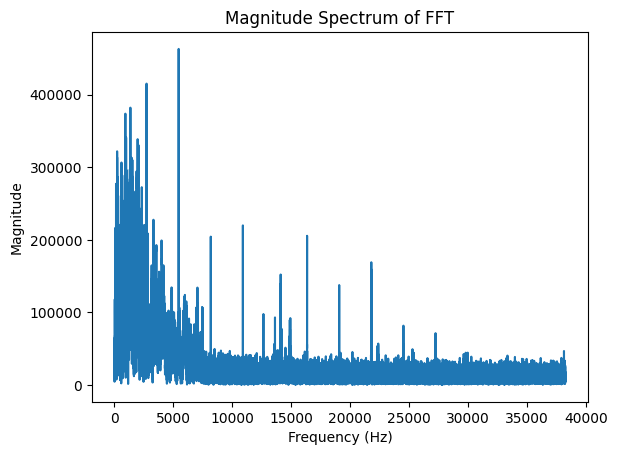

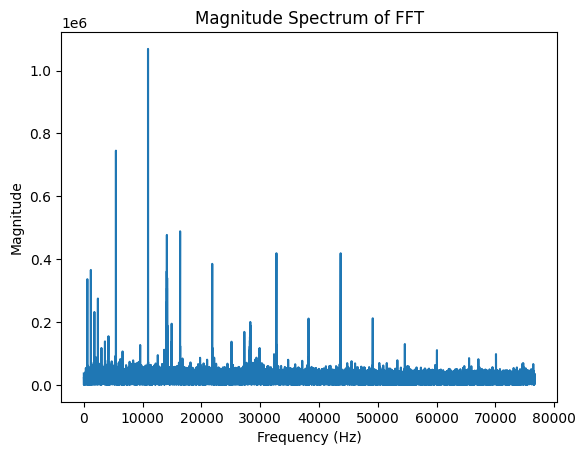

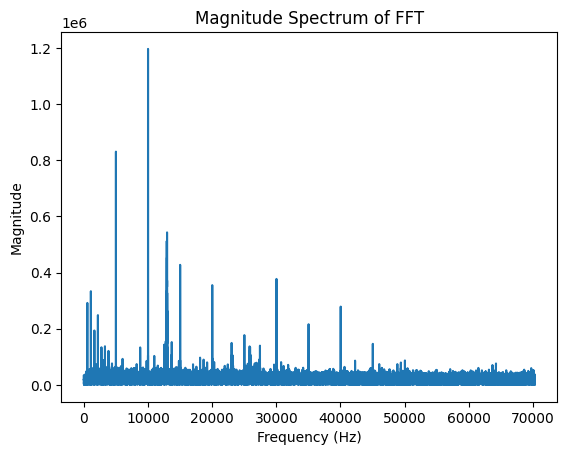

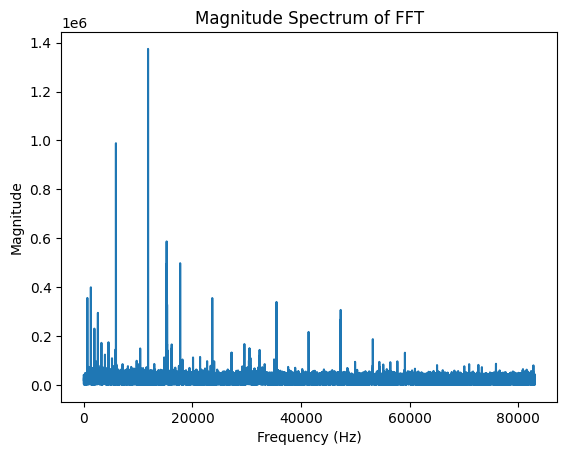

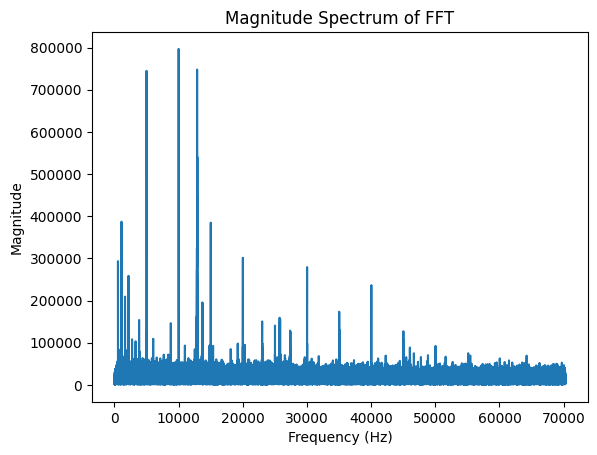

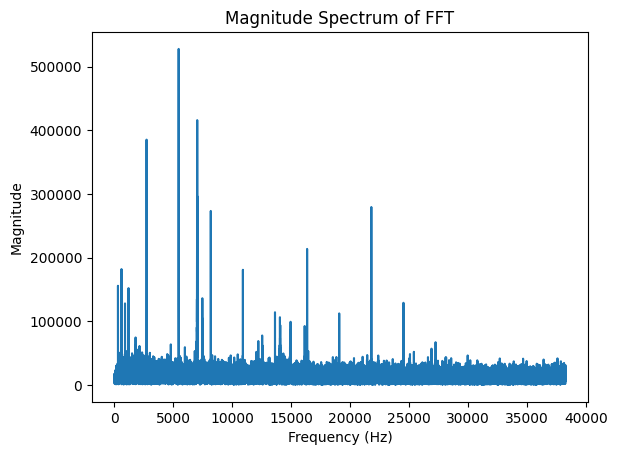

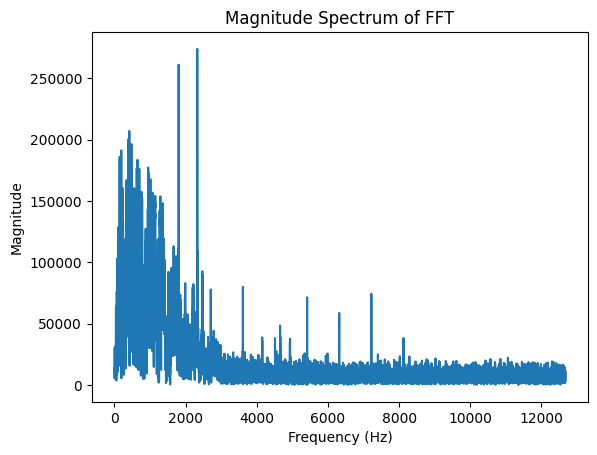

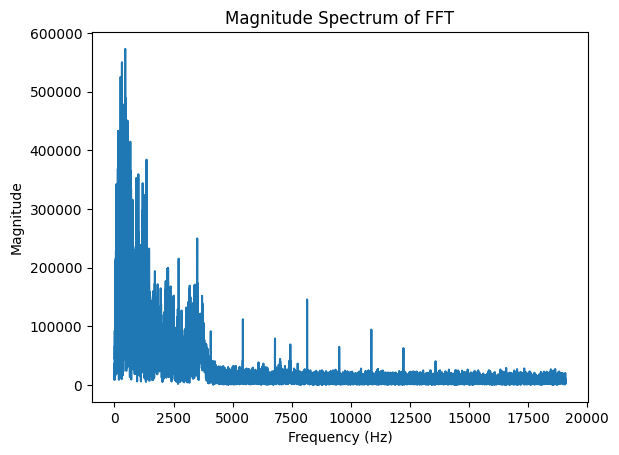

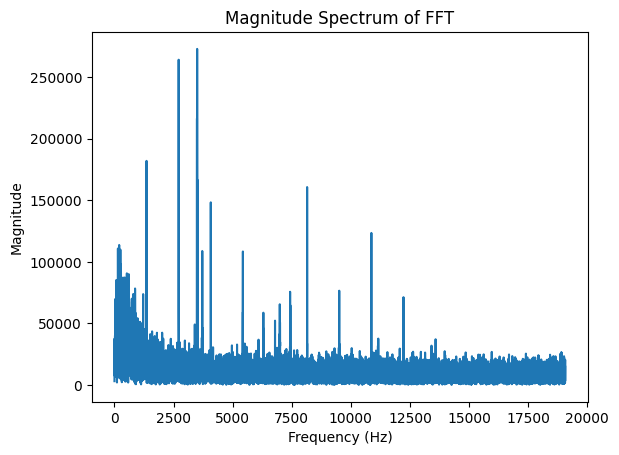

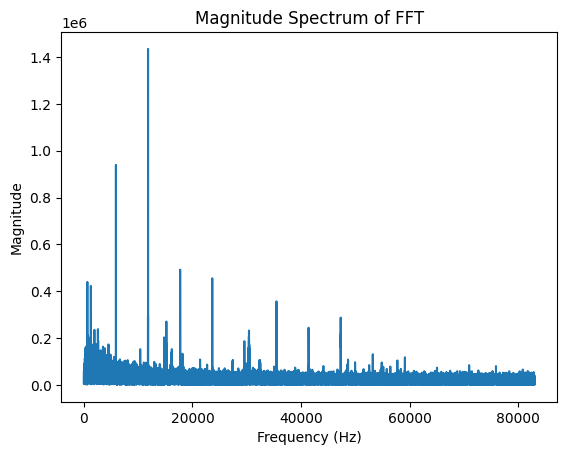

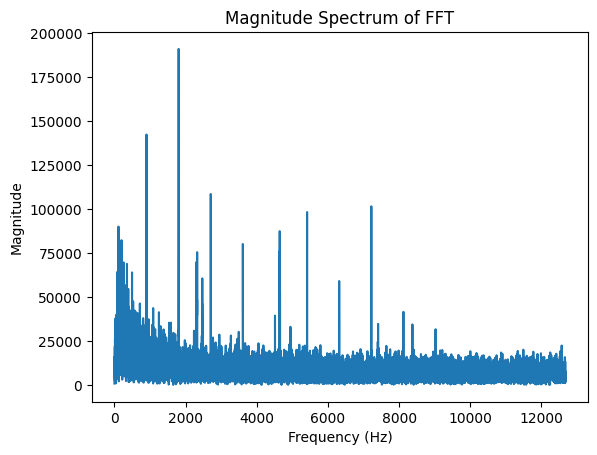

In [11]:
df_new['fft_result'] = df_new['rx1_freq_a_channel_i_data'].apply(apply_fft)

In [12]:
df_new

,rx1_freq_a_channel_i_data,task,fft_result
0,"[34256.0, 34224.0, 34176.0, 34224.0, 34176.0, ...",0,"[63866.633, 28138.633, 16732.535, 9243.94, 176..."
1,"[34128.0, 34208.0, 34080.0, 34096.0, 34224.0, ...",1,"[36446.33, 26938.664, 8438.225, 25340.814, 101..."
2,"[34096.0, 34080.0, 34000.0, 34144.0, 34144.0, ...",2,"[16121.942, 16389.709, 20378.238, 18008.832, 3..."
3,"[34176.0, 34256.0, 34128.0, 34192.0, 34208.0, ...",3,"[25902.105, 24166.662, 19256.51, 31418.736, 41..."
4,"[34096.0, 34160.0, 34192.0, 34224.0, 34128.0, ...",4,"[28523.443, 22565.951, 21841.525, 21665.746, 9..."
5,"[34240.0, 34064.0, 34192.0, 34112.0, 34176.0, ...",5,"[9808.154, 7333.717, 17257.6, 7119.4424, 4648...."
6,"[34208.0, 34272.0, 34320.0, 34128.0, 34160.0, ...",6,"[11053.9, 10248.211, 13383.926, 6235.445, 5518..."
7,"[34080.0, 34064.0, 34208.0, 34176.0, 34176.0, ...",7,"[31406.787, 17285.324, 9378.064, 8595.317, 100..."
8,"[34176.0, 34160.0, 34160.0, 34128.0, 34080.0, ...",8,"[3139.372, 7798.3477, 19570.105, 26941.668, 19..."
9,"[34240.0, 34240.0, 34192.0, 34224.0, 34160.0, ...",9,"[56173.242, 23008.146, 48783.496, 27653.242, 1..."


In [9]:
a = data['a1_rx']['P1']
a_fft = fft(a)
a_fft_magnitude = np.abs(a_fft)
a_fft_magnitude_no_dc = a_fft_magnitude[1:len(a_fft)//2]

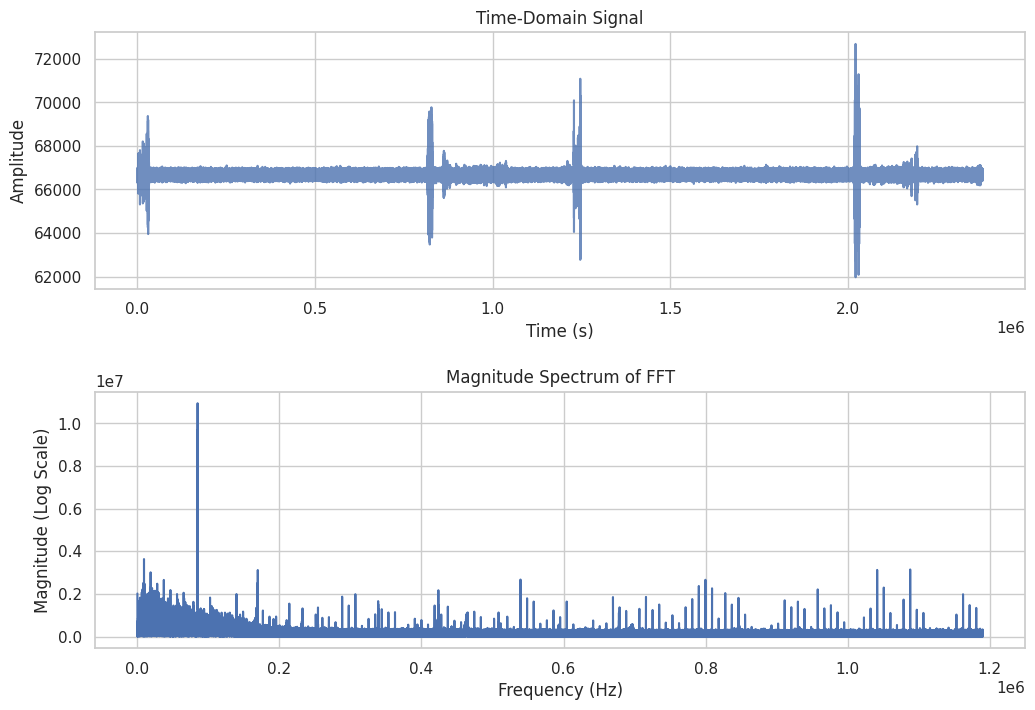

In [10]:
# Generate frequency axis (for positive frequencies only)

# Plot both the time-domain signal and the frequency spectrum
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid')
plt.subplots_adjust(hspace=0.4)

# Time-domain plot
plt.subplot(2, 1, 1)
sns.lineplot(a, color='b', alpha=0.8)
plt.title("Time-Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
#plt.xlim(0, 5000)
# Frequency-domain plot (Magnitude Spectrum)
plt.subplot(2, 1, 2)
#sns.lineplot(x=np.arange(1, len(a_fft)//2)[1:], y=a_fft_magnitude_no_dc[1:])
sns.lineplot(x=np.arange(1, len(a_fft)//2), y=a_fft_magnitude_no_dc)
#plt.yscale('log')  # Use log scale to make smaller values visible
plt.title("Magnitude Spectrum of FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
#plt.xlim(0, 5000)
#plt.subplot(3, 1, 3)
#sns.lineplot(x=np.arange(1, len(a_fft)), y=a_fft_magnitude[1:])
#plt.title("Magnitude Spectrum of FFT (double)")
#plt.xlabel("Frequency (Hz)")
#plt.ylabel("Magnitude (Log Scale)")
plt.show()

### Apply FFT to all the participants

In [9]:
columns_to_fft = ['rx1_freq_a_channel_i_data', 'a1_rx', 'a2_rx', 'b1_rx']

# Initialize a list to collect rows for the FFT results
fft_rows = []

# Iterate through each row and compute FFT
for i in range(42):  # iterate each row
    fft_row = {}  # Create a dictionary for the current row's FFT results
    for col in columns_to_fft:  # iterate the target columns
        target_dt = data.iloc[i][col]
        fft_result = fft(target_dt)  # Perform FFT
        fft_result = np.abs(fft_result)
        fft_result = fft_result[1: len(fft_result)//2]
        fft_row[f'{col}_fft'] = fft_result  # Store the FFT result
    
    fft_rows.append(fft_row)  # Append the dictionary to the list

# Create a DataFrame from the collected FFT results
fft_results = pd.DataFrame(fft_rows)

# Optionally, rename the index if desired
fft_results.index = [f'P_{i+1}' for i in range(len(fft_results))]


In [10]:
fft_results.to_parquet('/home/Shared/xinyi/blob1/thesis/radar_112/fft_results.parquet')

In [11]:
fft_results = pd.read_parquet('/home/Shared/xinyi/blob1/thesis/radar_112/fft_results.parquet')

In [12]:
fft_results

,rx1_freq_a_channel_i_data_fft,a1_rx_fft,a2_rx_fft,b1_rx_fft
P_1,"[315585.0, 701237.6, 257473.36, 268106.12, 253...","[2020050.5476694084, 945429.4205027812, 135831...","[3595801.9120124793, 936559.6365218558, 149473...","[3079353.413562232, 629951.3394764003, 521263...."
P_2,"[242822.78, 107887.32, 53552.938, 33624.254, 1...","[179873.53345310717, 265549.1509238658, 55555....","[536011.8250888586, 343557.74452282814, 241720...","[502452.95405990706, 206477.85686982, 39546.20..."
P_3,"[395055.0, 258088.44, 281768.75, 215741.28, 63...","[808161.8629139253, 333423.4447165818, 663094....","[377791.1066017008, 222929.74523042954, 678835...","[702850.8705988947, 211478.37266740794, 788199..."
P_4,"[634275.56, 107938.85, 275393.84, 280727.2, 48...","[388422.8479104515, 376537.3734730553, 557321....","[697079.0169170721, 42557.39094643609, 443066....","[372530.8031056316, 525829.2894569817, 597985...."
P_5,"[193053.69, 101619.01, 188739.3, 287365.47, 25...","[586135.4696454544, 393243.3654223553, 412766....","[632758.4560167368, 415896.4931333939, 449565....","[785291.257848989, 560106.5227789655, 157704.6..."
P_6,"[421946.94, 146752.83, 85027.086, 412795.53, 1...","[274017.9157851057, 87946.17577013992, 448627....","[42193.4368141134, 76378.81382644505, 486331.6...","[266445.7225165317, 17696.447113255712, 466699..."
P_7,"[507797.03, 113120.734, 228549.52, 297458.1, 1...","[536230.6899300363, 643454.7071267399, 245645....","[773351.5295012245, 371411.364486355, 127839.5...","[180499.62542518054, 719054.5989759672, 265469..."
P_8,"[314098.78, 231677.25, 207286.98, 188023.47, 1...","[280609.65597723675, 250623.29314896758, 48535...","[95321.72158051467, 298787.9107789822, 581016....","[158817.84852315192, 141744.65709953415, 52490..."
P_9,"[616813.75, 181615.84, 97288.49, 307599.84, 27...","[496137.27602509886, 196632.91407568942, 51383...","[507481.6855843584, 346451.95068804646, 498641...","[363079.622616693, 111478.66149776202, 345954...."
P_10,"[388499.9, 207844.89, 147888.58, 259926.98, 11...","[501389.33907777956, 266185.7523069496, 64841....","[575404.8321992408, 267833.30031185615, 163495...","[481103.8458294754, 319304.85718841956, 128769..."


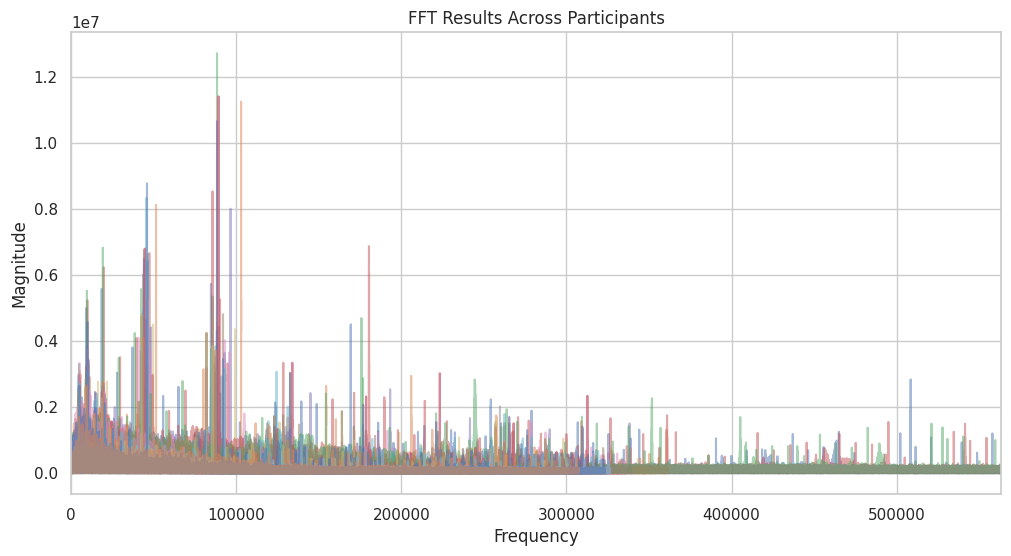

In [13]:
fft_column = 'rx1_freq_a_channel_i_data_fft'

# Create a new figure
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')
sns.color_palette("pastel")
# Iterate through each row and plot
for i in range(len(fft_results)):
    # Extract the FFT result for the current row
    fft_values = fft_results[fft_column].iloc[i]
    fft_magnitude = np.abs(fft_values)
    fft_magnitude_no_dc = fft_magnitude[1:len(fft_values)//2]

    # Plot the FFT result
    sns.lineplot(x=np.arange(1, len(fft_values)//2), y=fft_magnitude_no_dc, alpha=0.5)

# Customize the plot
plt.title('FFT Results Across Participants')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 563199)
plt.show()

Since the length of freqency ranges are different for each paricipants, and the larger value of the frequency is less interesting than the lower one, so it will be cut instead of padding...

## PCA on FFT

### Try PCA on single task FFT

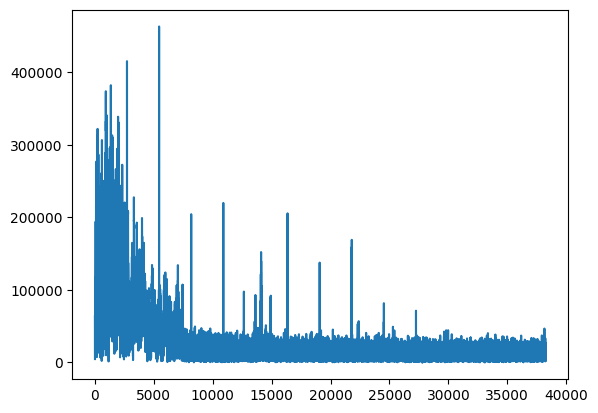

In [13]:
single_task_fft = df_new['fft_result'][0]
plt.plot(single_task_fft)

In [155]:
single_task_fft = single_task_fft.reshape(-1, 1).T
single_task_fft.shape

(1, 38271)

In [154]:
pca = PCA(n_components=120)
components = pca.fit_transform(single_task_fft)
plt.plot(components[:, :5])
plt.grid(False)
plt.show()

ValueError: n_components=120 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

Does not work :(

### PCA on all the tasks, and choose 3 of the tasks which have the highest score in the three components

In [14]:
fft_for_pca = df_new['fft_result']

In [15]:
#fft_pca = fft_results['rx1_freq_a_channel_i_data_fft']
min_length = min(fft_for_pca.apply(len))
fft_for_pca = np.array(fft_for_pca)
truncated_arrays = np.array([arr[:min_length] for arr in fft_for_pca])
#truncated_arrays = truncated_arrays.T
truncated_arrays.shape

(11, 12671)

For each participant, apply PCA on FFT result and find the top three components.<br>
There are 42 participants, so 42 * 3 = 126 components for k-means

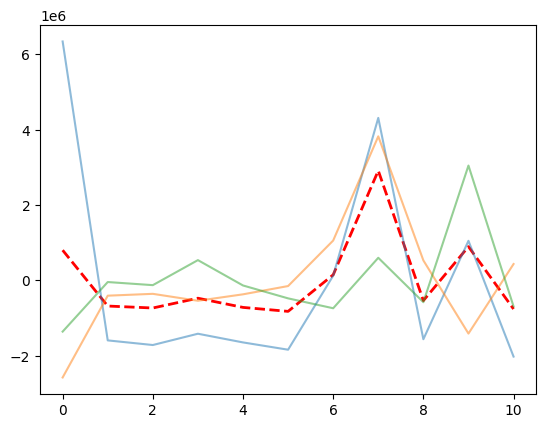

In [18]:
pca = PCA(n_components=11)
components = pca.fit_transform(truncated_arrays)
mean_values = np.mean(components[:, :3], axis=1)
plt.plot(mean_values, linestyle='--', color='red', linewidth=2)
plt.plot(components[:, :3], alpha=0.5)
#plt.plot(components)
plt.grid(False)
plt.show()

In [21]:
# Get the indices of the top three tasks based on the mean values
top_indices = np.argsort(mean_values)[-4:][::-1]  # Get the last three indices and reverse them for descending order

# Print the indices of the top three tasks
print("Indices of the top three tasks:", top_indices)

Indices of the top three tasks: [7 9 0 6]


In [22]:
top_tasks_df = df_new[df_new['task'].isin(top_indices)]

In [23]:
top_tasks_df

,rx1_freq_a_channel_i_data,task,fft_result
0,"[34256.0, 34224.0, 34176.0, 34224.0, 34176.0, ...",0,"[63866.633, 28138.633, 16732.535, 9243.94, 176..."
6,"[34208.0, 34272.0, 34320.0, 34128.0, 34160.0, ...",6,"[11053.9, 10248.211, 13383.926, 6235.445, 5518..."
7,"[34080.0, 34064.0, 34208.0, 34176.0, 34176.0, ...",7,"[31406.787, 17285.324, 9378.064, 8595.317, 100..."
9,"[34240.0, 34240.0, 34192.0, 34224.0, 34160.0, ...",9,"[56173.242, 23008.146, 48783.496, 27653.242, 1..."


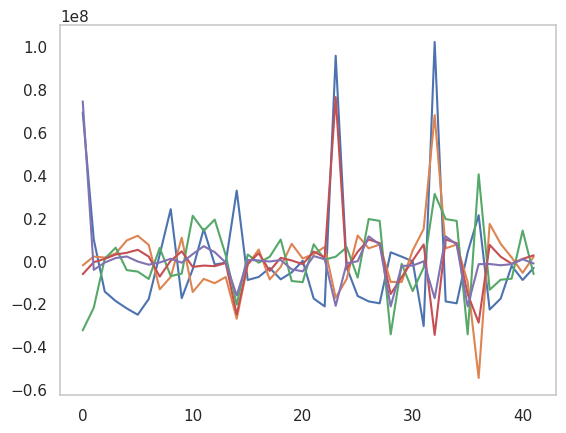

In [71]:
#Transposed
truncated_arrays_T = truncated_arrays.T
pca = PCA(n_components=42)
components_T = pca.fit_transform(truncated_arrays_T)
plt.plot(components[:, :5])
plt.grid(False)
plt.show()

### K-means

In [72]:
dominant_components = components[:, :3]
dominant_components.shape

(42, 3)

In [76]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=32)
kmeans.fit(dominant_components)

KMeans(n_clusters=5, random_state=32)

In [77]:
labels = kmeans.labels_
labels.shape

(42,)

In [5]:
image_paths

NameError: name 'image_paths' is not defined

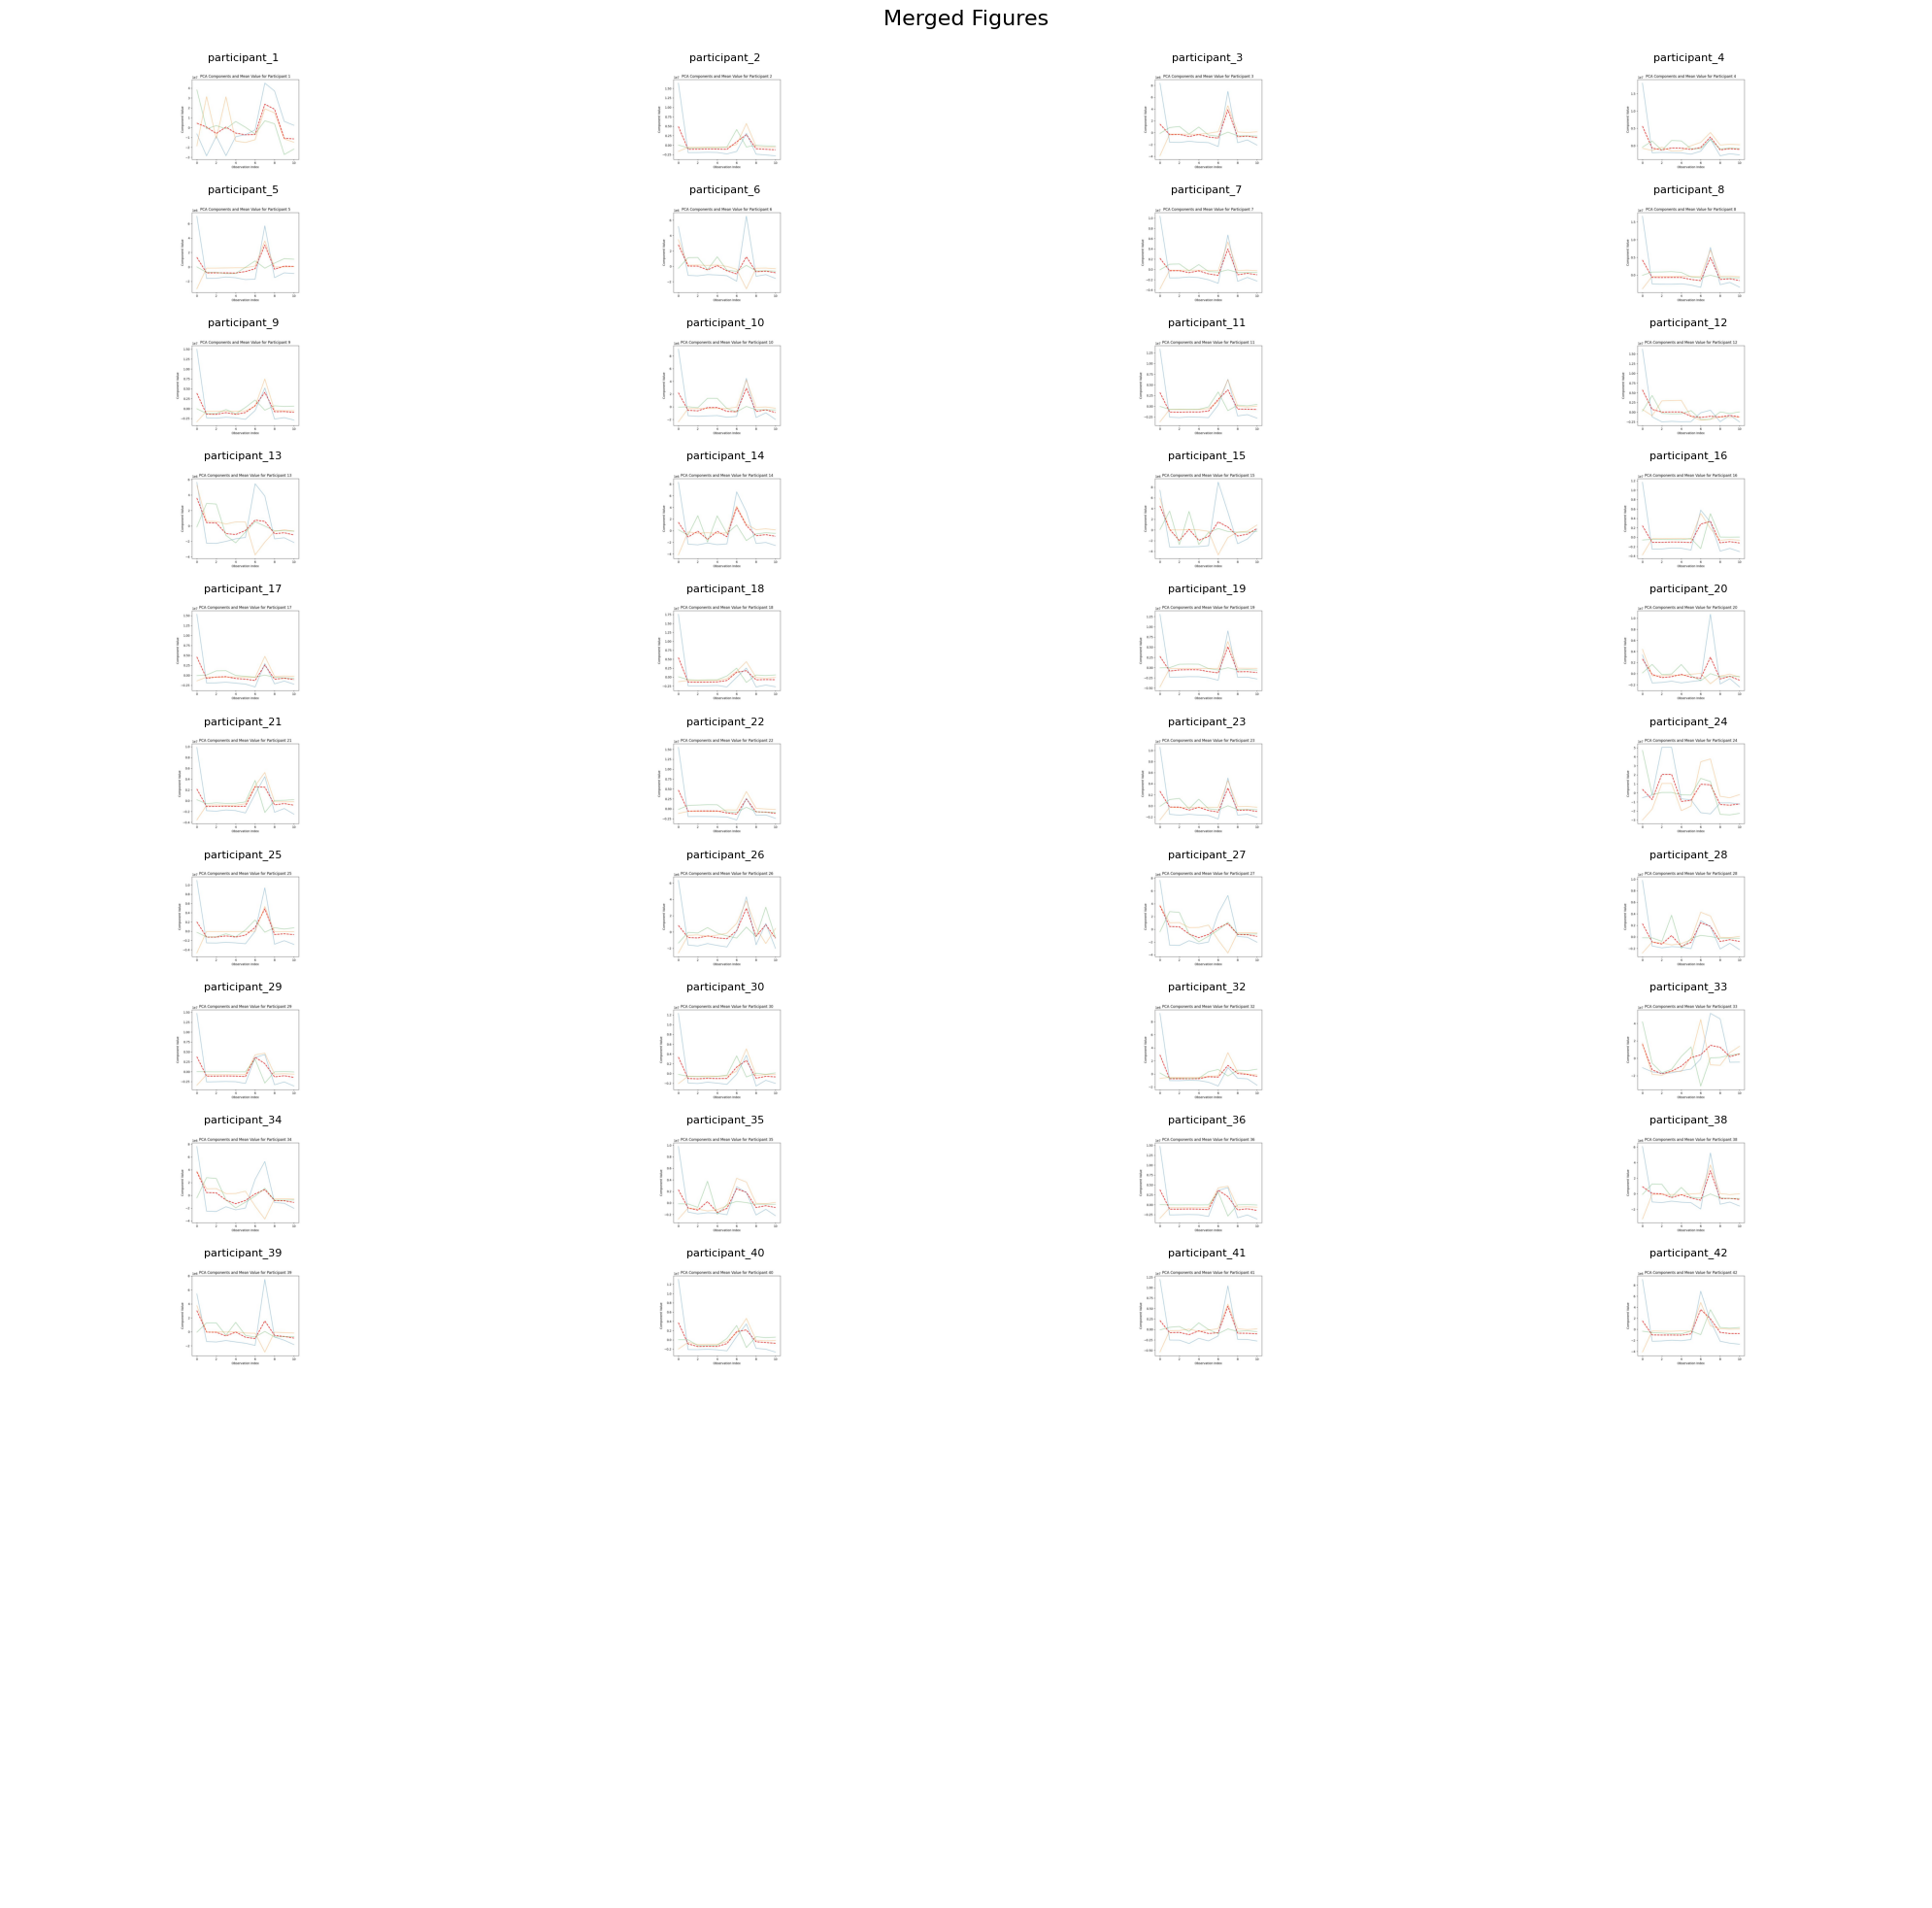

In [9]:
import os
import re
import matplotlib.pyplot as plt
from PIL import Image

def extract_participant_number(filename):
    # Use a regular expression to find numbers in the filename
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))  # Return the first found number as an integer
    return float('inf')  # Return a large number if no number is found

def merge_figures_with_titles(folder_path, rows=14, cols=3):
    # Get all image file paths from the folder, and sort them by participant number
    image_paths = sorted(
        [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))],
        key=lambda x: extract_participant_number(os.path.basename(x))
    )
    
    # Create a large figure with specified number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    fig.suptitle("Merged Figures", fontsize=16)
    
    # Flatten the axes array to iterate over them easily
    axes = axes.flatten()
    
    # Plot each image in a separate subplot with file name as title
    for idx, img_path in enumerate(image_paths):
        if idx < len(axes):  # Check to avoid index errors if there are fewer images than subplots
            img = Image.open(img_path)  # Open the image
            axes[idx].imshow(img)       # Display the image on the subplot
            axes[idx].axis('off')       # Hide the axes for a cleaner display
            
            # Extract the file name without extension and set as title
            title = os.path.basename(img_path).split('.')[0]
            axes[idx].set_title(title, fontsize=8)  # Set file name as title
        
    # Turn off any unused subplots if there are fewer images than grid cells
    for j in range(len(image_paths), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust space to include the main title
    plt.show()

# Use the function by providing the folder containing your images
folder_path = '/home/Shared/xinyi/blob1/thesis/figure/result_pca'
merge_figures_with_titles(folder_path, rows=14, cols=4)

In [11]:
import pandas as pd
pca_result = pd.read_parquet('/home/Shared/xinyi/blob1/thesis/pca_result.parquet')
pca_result

FileNotFoundError: [Errno 2] No such file or directory: '/home/Shared/xinyi/blob1/thesis/pca_result.parquet'

In [12]:
data_check = pd.read_parquet('/home/Shared/xinyi/blob1/thesis/radar_112/all_part_tasks.parquet')
data_check

,rx1_freq_a_channel_i_data,task,fft_result
0,"[34288.0, 34368.0, 34288.0, 34336.0, 34272.0, ...",0,"[478145.28, 323318.62, 210751.69, 112091.62, 2..."
1,"[34160.0, 34144.0, 34144.0, 34160.0, 34064.0, ...",1,"[585432.56, 265504.25, 132066.03, 161683.8, 88..."
2,"[34208.0, 34256.0, 34128.0, 34112.0, 34128.0, ...",2,"[490926.34, 205329.4, 79549.08, 261047.17, 179..."
3,"[34096.0, 34272.0, 34096.0, 34160.0, 34128.0, ...",3,"[495987.25, 124901.99, 147023.14, 231230.67, 1..."
4,"[34016.0, 34208.0, 34096.0, 34160.0, 34128.0, ...",4,"[413784.2, 100740.12, 254898.19, 99958.34, 184..."
...,...,...,...
446,"[34112.0, 34112.0, 34256.0, 34256.0, 34160.0, ...",6,"[34106.547, 22214.77, 49620.086, 27806.309, 51..."
447,"[34448.0, 34416.0, 34256.0, 34208.0, 34128.0, ...",7,"[17774.268, 9205.3545, 10348.392, 20992.066, 2..."
448,"[34224.0, 34224.0, 34048.0, 34128.0, 34080.0, ...",8,"[8603.157, 18780.223, 21862.367, 8005.453, 190..."
449,"[34080.0, 34112.0, 34224.0, 34128.0, 34144.0, ...",9,"[11742.4375, 17208.99, 9217.896, 7320.8594, 28..."
